In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from iminuit import Minuit
# from sklearn.metrics import f1_score

In [2]:
detA = pd.read_csv("../data/DetectorA.csv", header=None, names=["event_id", "class_score", "energy"])
detB = pd.read_csv("../data/DetectorB.csv", header=None, names=["event_id", "class_score", "energy"])
detC = pd.read_csv("../data/DetectorC.csv", header=None, names=["event_id", "class_score", "energy"])
print(detA)

       event_id  class_score    energy
0      734628.0        0.440  2123.514
1      229218.0        0.179  1017.985
2      428880.0        0.028  1862.961
3        1990.0        0.080  1619.836
4       55401.0        0.065  2611.720
...         ...          ...       ...
39995  920596.0        0.324  2278.508
39996  778459.0        0.209  2377.462
39997  484579.0        0.554  2612.247
39998  563791.0        0.018  1216.414
39999  729917.0        0.151  1944.577

[40000 rows x 3 columns]


## Converting events to energy spectrums

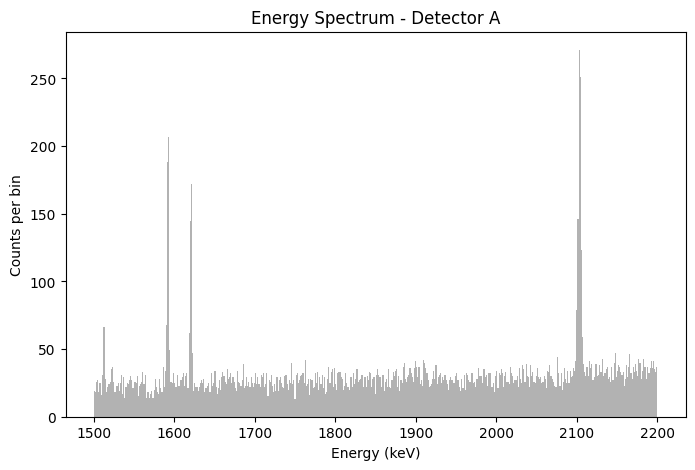

In [27]:
# Energy range for the spectrum (keV)
energy_min = 1500
energy_max = 2200
n_bins = 500  # adjust for resolution

# Histogram
counts, bin_edges = np.histogram(detA['energy'], bins=n_bins, range=(energy_min, energy_max))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Plot
plt.figure(figsize=(8,5))
plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, color='gray')
plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin")
plt.title("Energy Spectrum - Detector A")
plt.show()

In [28]:
# Define the window around the 1592 peak for fitting
peak_center = 1592
window = 20  # keV, adjust as needed
mask = (bin_centers >= peak_center - window) & (bin_centers <= peak_center + window)

# Extract counts and bin centers in the fitting window
fit_bins = bin_centers[mask]
fit_counts = counts[mask]

# Fit Gaussian + linear background in this window/

In [29]:
###

<ValueView A=210.05253084607114 mu=1592.346068699377 sigma=1.1114692650881604 slope=0.20690006717126475 intercept=-304.25328180561513>


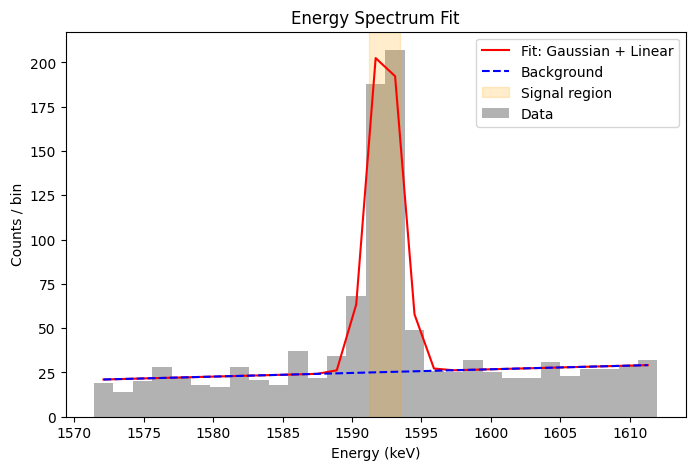

Fitted peak μ = 1592.35 keV, σ = 1.11 keV
Signal region: 1591.23 – 1593.46 keV
Signal = 344.6, Background = 50.4, S/B = 6.83


In [30]:
def fit_signal_background(bins, counts):
    """Given the bins and counts near a peak, fit a Gaussian signal + linear background."""
    
    def fit_function(x, A, mu, sigma, slope, intercept):
        """Gaussian + linear background."""
        gauss = A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        background = slope * x + intercept
        return gauss + background

    def chi2(A, mu, sigma, slope, intercept):
        expected = fit_function(bins, A, mu, sigma, slope, intercept)
        return np.sum((counts - expected) ** 2 / (expected + 1e-6))  # avoid division by zero

    # Minuit fit
    fit = Minuit(
        chi2,
        A=10,
        mu=1592,
        sigma=1.0734,
        slope=0.01,
        intercept=0,
    )
    fit.errordef = 1
    fit.migrad()

    # Extract best-fit parameters
    A, mu, sigma, slope, intercept = (
        fit.values["A"],
        fit.values["mu"],
        fit.values["sigma"],
        fit.values["slope"],
        fit.values["intercept"],
    )

    print(fit.values)
    # Signal region: mu ± sigma
    signal_region = (bins >= mu - abs(sigma)) & (bins <= mu + abs(sigma))

    # Fitted curves
    y_fit = fit_function(bins, A, mu, sigma, slope, intercept)
    y_bkg = slope * bins + intercept

    total_counts_region = np.sum(counts[signal_region])
    background_counts_region = np.sum(y_bkg[signal_region])
    signal_counts_region = total_counts_region - background_counts_region

    S = signal_counts_region
    B = background_counts_region

    bin_width = bins[1] - bins[0]

    # Plot
    plt.figure(figsize=(8,5))
    plt.bar(bins, counts, width=bin_width, color='gray', alpha=0.6, label='Data')
    plt.plot(bins, y_fit, 'r-', label='Fit: Gaussian + Linear')
    plt.plot(bins, y_bkg, 'b--', label='Background')
    plt.axvspan(mu - sigma, mu + sigma, color='orange', alpha=0.2, label='Signal region')
    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts / bin")
    plt.title("Energy Spectrum Fit")
    plt.legend()
    plt.show()

    print(f"Fitted peak μ = {mu:.2f} keV, σ = {sigma:.2f} keV")
    print(f"Signal region: {mu - sigma:.2f} – {mu + sigma:.2f} keV")
    print(f"Signal = {S:.1f}, Background = {B:.1f}, S/B = {S/B:.2f}")

    return S, B

# Example usage:
S, B = fit_signal_background(fit_bins, fit_counts)


<ValueView A=240.50421464459296 mu=2103.2008403852783 sigma=1.7332077267448953 slope=0.09066347362357895 intercept=-158.3143066675864>


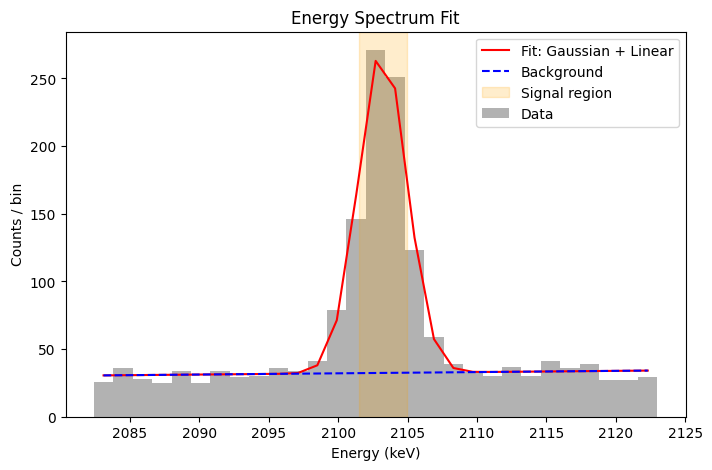

Fitted peak μ = 2103.20 keV, σ = 1.73 keV
Signal region: 2101.47 – 2104.93 keV
Signal = 457.2, Background = 64.8, S/B = 7.06


In [31]:
def fit_background(bins, counts):
    """Given the bins and counts near a peak, fit a Gaussian signal + linear background."""
    
    def fit_function(x, A, mu, sigma, slope, intercept):
        """Gaussian + linear background."""
        gauss = A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        background = slope * x + intercept
        return gauss + background

    def chi2(A, mu, sigma, slope, intercept):
        expected = fit_function(bins, A, mu, sigma, slope, intercept)
        return np.sum((counts - expected) ** 2 / (expected + 1e-6))  # avoid division by zero

    # Minuit fit
    fit = Minuit(
        chi2,
        A=100,
        mu=2103,
        sigma=1.6693,
        slope=0.01,
        intercept=0,
    )
    fit.errordef = 1
    fit.migrad()

    # Extract best-fit parameters
    A, mu, sigma, slope, intercept = (
        fit.values["A"],
        fit.values["mu"],
        fit.values["sigma"],
        fit.values["slope"],
        fit.values["intercept"],
    )

    print(fit.values)
    # Signal region: mu ± sigma
    signal_region = (bins >= mu - abs(sigma)) & (bins <= mu + abs(sigma))

    # Fitted curves
    y_fit = fit_function(bins, A, mu, sigma, slope, intercept)
    y_bkg = slope * bins + intercept

    total_counts_region = np.sum(counts[signal_region])
    background_counts_region = np.sum(y_bkg[signal_region])
    signal_counts_region = total_counts_region - background_counts_region

    S = signal_counts_region
    B = background_counts_region

    bin_width = bins[1] - bins[0]

    # Plot
    plt.figure(figsize=(8,5))
    plt.bar(bins, counts, width=bin_width, color='gray', alpha=0.6, label='Data')
    plt.plot(bins, y_fit, 'r-', label='Fit: Gaussian + Linear')
    plt.plot(bins, y_bkg, 'b--', label='Background')
    plt.axvspan(mu - sigma, mu + sigma, color='orange', alpha=0.2, label='Signal region')
    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts / bin")
    plt.title("Energy Spectrum Fit")
    plt.legend()
    plt.show()

    print(f"Fitted peak μ = {mu:.2f} keV, σ = {sigma:.2f} keV")
    print(f"Signal region: {mu - sigma:.2f} – {mu + sigma:.2f} keV")
    print(f"Signal = {S:.1f}, Background = {B:.1f}, S/B = {S/B:.2f}")

    return S, B

peak_center = 2103
window = 20  # keV, adjust as needed
mask = (bin_centers >= peak_center - window) & (bin_centers <= peak_center + window)
background_bins = bin_centers[mask]#bin_centers[(bin_centers >= 2083) & (bin_centers <= 2123)]
background_counts = counts[mask]#counts[(bin_centers >= 2083) & (bin_centers <= 2123)]
# Example usage:
S, B = fit_background(background_bins, background_counts)


In [32]:
peak1 = 1592.37 
sigma1 = 1.06
signal_region = (
    (bin_centers >= (peak1 - 1*sigma1)) & (bin_centers <= (peak1 + 1*sigma1)) # Signal region is 1 sigma around peak
)
signal_sideband = (
    ((bin_centers >= (peak1 - 2*sigma1)) & (bin_centers <= (peak1 - 1*sigma1))) | # Sidebands are 1-2 sigma away from peak
    ((bin_centers >= (peak1 + 1*sigma1)) & (bin_centers <= (peak1 + 2*sigma1)))
)
B_sig = counts[signal_sideband].sum() # Background in sidebands
Ns = counts[signal_region].sum() # Total counts in signal region

peak2 = 2103.21
sigma2 = 1.73
bkg_region = (bin_centers >= peak2 - 1 * abs(sigma2)) & (bin_centers <= peak2 + 1 * abs(sigma2))
bkg_sideband = (
    ((bin_centers >= (peak2 - 2*sigma2)) & (bin_centers <= (peak2 - 1*sigma2))) |
    ((bin_centers >= (peak2 + 1*sigma2)) & (bin_centers <= (peak2 + 2*sigma2)))
)
N_b = counts[bkg_region].sum() # Total counts in background region
B_bkg = counts[bkg_sideband].sum() # Background in sidebands

tau = 1

1 1
0.981651376146789 0.7126436781609196
0.9694189602446484 0.5402298850574713
0.9663608562691132 0.4367816091954023
0.963302752293578 0.25862068965517243
0.944954128440367 0.13218390804597702
0.9113149847094801 0.07471264367816093
0.8837920489296636 0.06321839080459771
0.8654434250764526 0.034482758620689655
0.8562691131498471 0.04597701149425287
0.8501529051987767 0.011494252873563218
0.8134556574923547 0
0.7951070336391437 0.022988505747126436
0.7859327217125383 0
0.7706422018348624 0
0.7553516819571865 0
0.7431192660550459 0
0.7339449541284404 0
0.7186544342507645 0
0.7155963302752294 0
0.709480122324159 0
0.6941896024464832 0
0.6819571865443425 0
0.6758409785932722 0
0.6697247706422018 0
0.6636085626911316 0
0.6483180428134556 0
0.6452599388379205 0
0.6422018348623854 0
0.636085626911315 0
0.6299694189602446 0
0.6207951070336392 0
0.617737003058104 0
0.6055045871559633 0
0.5932721712538226 0
0.5902140672782875 0
0.5749235474006116 0.005747126436781609
0.5596330275229358 0.03448275

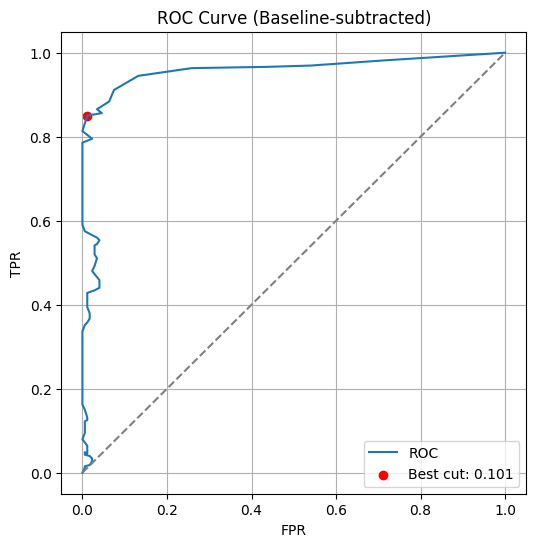

In [33]:
thresholds = np.linspace(0, 1, 100)
tprs = []
fprs = []

for t in thresholds:
    cut = detA['class_score'] >= t
    counts_cut = np.histogram(detA[cut]['energy'], bins=bin_edges, range=(energy_min, energy_max))[0]
    Nc_sig = counts_cut[signal_region].sum()
    Bc_sig = counts_cut[signal_sideband].sum()
    Nc_bkg = counts_cut[bkg_region].sum()
    Bc_bkg = counts_cut[bkg_sideband].sum()
    
    TPR = max(0, min(1, (Nc_sig - tau * Bc_sig) / (Ns - tau * B_sig))) ### Using baseline subtracted cut efficiency at signal peak for TPR
    FPR = max(0, min(1, (Nc_bkg - tau * Bc_bkg) / (N_b - tau * B_bkg))) #### Using baseline subtracted cut efficiency at background peak for FPR

    tprs.append(TPR)
    fprs.append(FPR)
    print(TPR, FPR)

tprs = np.array(tprs)
fprs = np.array(fprs)
best_idx = np.argmax(tprs - fprs)
best_threshold = thresholds[best_idx]
best_TPR = tprs[best_idx]
best_FPR = fprs[best_idx]

print(f"Best threshold = {best_threshold:.3f}")
print(f"TPR at best threshold = {best_TPR:.3f}")
print(f"FPR at best threshold = {best_FPR:.3f}")

# Optional: plot ROC with best point highlighted
plt.figure(figsize=(6,6))
plt.plot(fprs, tprs, label="ROC")
plt.scatter(best_FPR, best_TPR, color='red', label=f"Best cut: {best_threshold:.3f}")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Baseline-subtracted)")
plt.grid()
plt.legend()
plt.show()

In [34]:
print(f"TPR for best threshold: {best_TPR:.3f}")
print(f"FPR for best threshold: {best_FPR:.3f}")

TPR for best threshold: 0.850
FPR for best threshold: 0.011


In [35]:
### Apply optimal cut and re-plot energy spectrum
optimal_cut = detA['class_score'] >= best_threshold
cut_counts, bin_edges_optimal = np.histogram(detA[optimal_cut]['energy'], bins=n_bins, range=(energy_min, energy_max))
cut_bin_centers = 0.5 * (bin_edges_optimal[1:] + bin_edges_optimal[:-1])


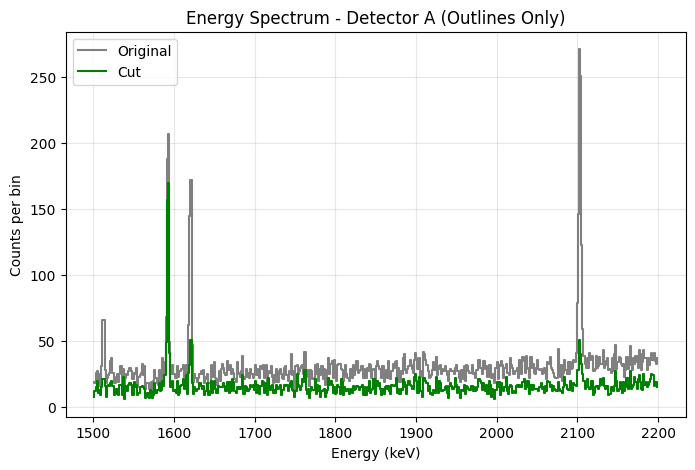

In [36]:
plt.figure(figsize=(8,5))

# Original histogram (outline)
plt.step(bin_centers, counts, where='mid', color='gray', label='Original')

# Filtered histogram (outline)
plt.step(cut_bin_centers, cut_counts, where='mid', color='green', label='Cut')

plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin")
plt.title("Energy Spectrum - Detector A (Outlines Only)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Evaluating FPR on the 2103 peak in Detector B

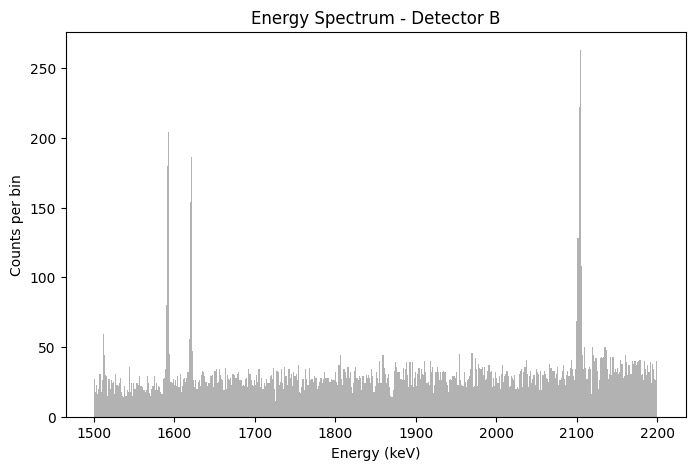

In [49]:
# Histogram
counts_B, bin_edges_B = np.histogram(detB['energy'], bins=n_bins, range=(energy_min, energy_max))

# Bin centers
bin_centers_B = 0.5 * (bin_edges_B[1:] + bin_edges_B[:-1])

# Plot
plt.figure(figsize=(8,5))
plt.bar(bin_centers_B, counts_B, width=bin_edges_B[1]-bin_edges_B[0], alpha=0.6, color='gray')
plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin")
plt.title("Energy Spectrum - Detector B")  # corrected title
plt.show()


<ValueView A=200.86977634156477 mu=1592.273649210621 sigma=1.187616364536867 slope=0.08184300441577687 intercept=-106.52931414104522>


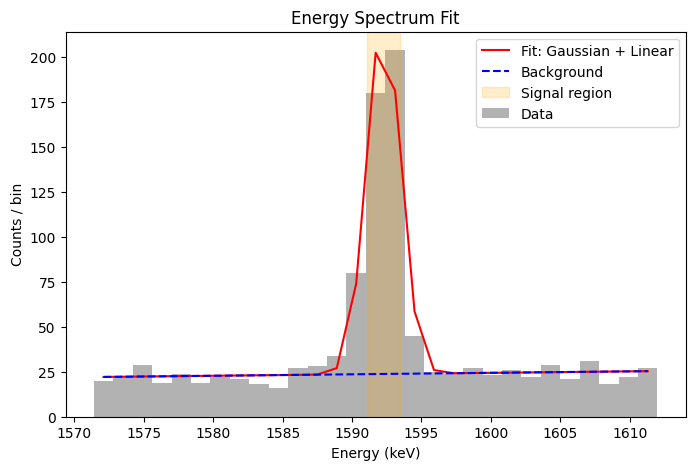

Fitted peak μ = 1592.27 keV, σ = 1.19 keV
Signal region: 1591.09 – 1593.46 keV
Signal = 336.4, Background = 47.6, S/B = 7.07


In [51]:
peak_center = 1592
window = 20  # keV, adjust as needed
mask = (bin_centers_B >= peak_center - window) & (bin_centers_B <= peak_center + window)
background_bins_B = bin_centers_B[mask]#bin_centers[(bin_centers >= 2083) & (bin_centers <= 2123)]
background_counts_B = counts_B[mask]#counts[(bin_centers >= 2083) & (bin_centers <= 2123)]
# Example usage:
S, B = fit_signal_background(background_bins_B, background_counts_B)


In [54]:
# Signal peak and width
sig_peak_B = 1592.27
sigma_peak_B = 1.19

# Signal region: ±1 sigma around the peak
signal_region_B = (
    (bin_centers_B >= (sig_peak_B - sigma_peak_B)) &
    (bin_centers_B <= (sig_peak_B + sigma_peak_B))
)

# Signal sidebands: 1-2 sigma away on either side of the peak
signal_sideband_B = (
    ((bin_centers_B >= (sig_peak_B - 2*sigma_peak_B)) & (bin_centers_B < (sig_peak_B - sigma_peak_B))) |
    ((bin_centers_B > (sig_peak_B + sigma_peak_B)) & (bin_centers_B <= (sig_peak_B + 2*sigma_peak_B)))
)

# Sum counts
N_signal_B = counts_B[signal_region_B].sum()        # Counts in signal region
B_signal_B = counts_B[signal_sideband_B].sum()    # Counts in sidebands

print(f"Detector B - Signal counts: {N_signal_B}, Sideband counts: {B_signal_B}")


Detector B - Signal counts: 384, Sideband counts: 125


<ValueView A=240.50421464459296 mu=2103.2008403852783 sigma=1.7332077267448953 slope=0.09066347362357895 intercept=-158.3143066675864>


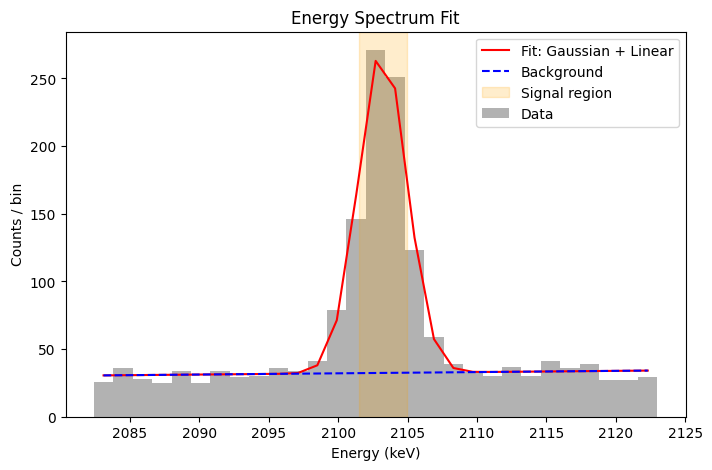

Fitted peak μ = 2103.20 keV, σ = 1.73 keV
Signal region: 2101.47 – 2104.93 keV
Signal = 457.2, Background = 64.8, S/B = 7.06


In [38]:
peak_center = 2103
window = 20  # keV, adjust as needed
mask = (bin_centers_B >= peak_center - window) & (bin_centers_B <= peak_center + window)
background_bins_B = bin_centers_B[mask]#bin_centers[(bin_centers >= 2083) & (bin_centers <= 2123)]
background_counts_B = counts[mask]#counts[(bin_centers >= 2083) & (bin_centers <= 2123)]
# Example usage:
S, B = fit_background(background_bins_B, background_counts_B)


In [39]:
bkg_peak_B = 2103.20
bkg_sigma_B = 1.73
bkg_region_B = (bin_centers_B >= bkg_peak_B - 1 * abs(bkg_sigma_B)) & (bin_centers_B <= bkg_peak_B + 1 * abs(bkg_sigma_B))
bkg_sideband_B = (
    ((bin_centers_B >= (bkg_peak_B - 2*bkg_sigma_B)) & (bin_centers_B <= (bkg_peak_B - 1*bkg_sigma_B))) |
    ((bin_centers_B >= (bkg_peak_B + 1*bkg_sigma_B)) & (bin_centers_B <= (bkg_peak_B + 2*bkg_sigma_B)))
)
N_b_B = counts_B[bkg_region_B].sum() # Total counts in background region
B_bkg_B = counts_B[bkg_sideband_B].sum() # Background in sidebands
print(f"Detector B - Background peak counts: {N_b_B}, Background in sidebands: {B_bkg_B}")

Detector B - Background peak counts: 485, Background in sidebands: 305


TPR for best threshold on Detector B: 0.873
FPR for best threshold on Detector B: 0.033


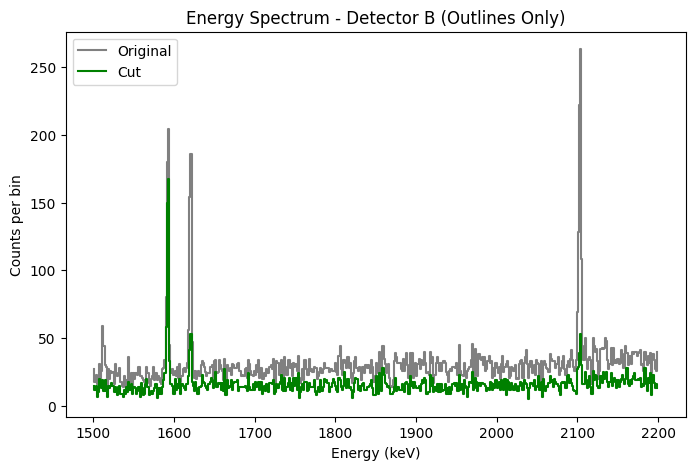

In [55]:
cut_counts_B, bin_edges_cut_B = np.histogram(detB[detB['class_score'] >= best_threshold]['energy'], bins=n_bins, range=(energy_min, energy_max))
cut_bin_centers_B = 0.5 * (bin_edges_cut_B[1:] + bin_edges_cut_B[:-1])

N_c_B = cut_counts_B[bkg_region_B].sum() # Total counts in background region after cut
B_c_B = cut_counts_B[bkg_sideband_B].sum() # Background in sidebands after cut
N_c_sig_B = cut_counts_B[signal_region_B].sum()
B_c_sig_B = cut_counts_B[signal_sideband_B].sum()

TPR = (N_c_sig_B - tau * B_c_sig_B) / (N_signal_B - tau * B_signal_B)
FPR = (N_c_B - tau * B_c_B) / (N_b_B - tau * B_bkg_B)
print(f"TPR for best threshold on Detector B: {TPR:.3f}")
print(f"FPR for best threshold on Detector B: {FPR:.3f}")
plt.figure(figsize=(8,5))
# Original histogram (outline)
plt.step(bin_centers_B, counts_B, where='mid', color='gray', label='Original')
# Filtered histogram (outline)
plt.step(cut_bin_centers_B, cut_counts_B, where='mid', color='green', label='Cut')
plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin")
plt.title("Energy Spectrum - Detector B (Outlines Only)")
plt.legend()


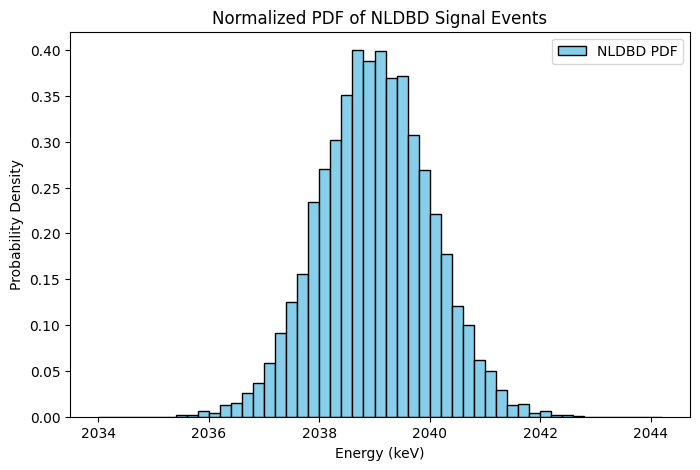

Integral over PDF: 1.0


In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 2039       # peak energy (keV)
sigma = 1       # width (keV)
n_events = 10000  # number of simulated signal events

# Generate events from Gaussian
events = np.random.normal(loc=mu, scale=sigma, size=n_events)

# Define histogram bins
bin_width = 0.2
bins = np.arange(mu - 5*sigma, mu + 5*sigma + bin_width, bin_width)

# Histogram
counts, bin_edges = np.histogram(events, bins=bins)

# Convert to PDF (normalize)
pdf = counts / (np.sum(counts) * bin_width)

# Bin centers for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot
plt.figure(figsize=(8,5))
plt.bar(bin_centers, pdf, width=bin_width, color='skyblue', edgecolor='k', label='NLDBD PDF')
plt.xlabel('Energy (keV)')
plt.ylabel('Probability Density')
plt.title('Normalized PDF of NLDBD Signal Events')
plt.legend()
plt.show()

# Optional: check area under PDF
print("Integral over PDF:", np.sum(pdf)*bin_width)
